In [386]:
# pip install eralchemy

import sqlite3
import pandas as pd
import numpy as np
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns

In [387]:
database = 'data/mlb_data.sqlite'
conn = sqlite3.connect(database)
# cursor = conn.cursor()

In [388]:
query = 'SELECT player_id, ' \
        'SUM(g_c) as catcher, ' \
        'SUM(g_1b) as firstbaseman, ' \
        'SUM(g_2b) as secondbaseman, ' \
        'SUM(g_3b) as thirdbaseman, ' \
        'SUM(g_ss) as shortstop, ' \
        'SUM(g_of) as outfielder ' \
        'from appearances group by player_id'
plyr_pos_df = pd.read_sql_query(query, conn)
plyr_pos_df.head()

,player_id,catcher,firstbaseman,secondbaseman,thirdbaseman,shortstop,outfielder
0,aardsda01,0,0,0,0,0,0
1,aaronha01,0,210,43,7,0,2760
2,aaronto01,0,232,7,10,0,138
3,aasedo01,0,0,0,0,0,0
4,abadan01,0,8,0,0,0,1


In [389]:
# Number of gams in 1 MLB season today (and since 1961) is 162, it was 140 in 1901 and 154 in 1920
positions = ['catcher', 'firstbaseman', 'secondbaseman', 'thirdbaseman', 'shortstop', 'outfielder']
min_games_at_max_pos = plyr_pos_df[positions].max(axis=1) > 140
plyr_pos_df = plyr_pos_df[min_games_at_max_pos]

In [390]:
plyr_pos_df['position'] = plyr_pos_df[positions].idxmax(axis=1)
plyr_pos_df.set_index('player_id', inplace=True)
plyr_pos_df.head()

,catcher,firstbaseman,secondbaseman,thirdbaseman,shortstop,outfielder,position
player_id,,,,,,,
aaronha01,0,210,43,7,0,2760,outfielder
aaronto01,0,232,7,10,0,138,firstbaseman
abbated01,0,0,419,20,388,3,secondbaseman
abbeych01,0,0,0,0,0,451,outfielder
abbotje01,0,0,0,0,0,185,outfielder


In [391]:
player_list = plyr_pos_df.index.tolist()

In [392]:
query = "SELECT player_id, name_first ||' ' || name_last AS name, debut, weight, height, bats as bat_hand, throws as throw_hand FROM player"
players_df = pd.read_sql_query(query, conn)
player_mask = players_df['player_id'].isin(player_list)
players_df = players_df[player_mask]
players_df.set_index('player_id', inplace=True)
display(players_df.head())
# players_df.info()

,name,debut,weight,height,bat_hand,throw_hand
player_id,,,,,,
aaronha01,Hank Aaron,1954-04-13,180,72,R,R
aaronto01,Tommie Aaron,1962-04-10,190,75,R,R
abbated01,Ed Abbaticchio,1897-09-04,170,71,R,R
abbeych01,Charlie Abbey,1893-08-16,169,68,L,L
abbotje01,Jeff Abbott,1997-06-10,190,74,R,L


In [393]:
players_df = pd.concat([players_df, plyr_pos_df['position']], axis=1)
players_df.head()

,name,debut,weight,height,bat_hand,throw_hand,position
player_id,,,,,,,
aaronha01,Hank Aaron,1954-04-13,180,72,R,R,outfielder
aaronto01,Tommie Aaron,1962-04-10,190,75,R,R,firstbaseman
abbated01,Ed Abbaticchio,1897-09-04,170,71,R,R,secondbaseman
abbeych01,Charlie Abbey,1893-08-16,169,68,L,L,outfielder
abbotje01,Jeff Abbott,1997-06-10,190,74,R,L,outfielder


In [394]:
print(players_df.isnull().sum())
print(players_df.info())

name          0
debut         0
weight        0
height        0
bat_hand      0
throw_hand    0
position      0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 4371 entries, aaronha01 to zwilldu01
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        4371 non-null   object
 1   debut       4371 non-null   object
 2   weight      4371 non-null   object
 3   height      4371 non-null   object
 4   bat_hand    4371 non-null   object
 5   throw_hand  4371 non-null   object
 6   position    4371 non-null   object
dtypes: object(7)
memory usage: 273.2+ KB
None


In [395]:
missing_height_or_weight = (players_df['height'] == '') | (players_df['weight'] == '')
display(players_df[missing_height_or_weight])

missing_bat_or_throw_hand = (players_df['bat_hand'] == '') | (players_df['throw_hand'] == '')
display(players_df[missing_bat_or_throw_hand])

print(players_df['bat_hand'].value_counts())
print(players_df['throw_hand'].value_counts())

,name,debut,weight,height,bat_hand,throw_hand,position
player_id,,,,,,,
barrysh01,Shad Barry,1899-05-30,,,R,R,outfielder
birchju01,Jud Birchall,1882-05-02,,,,,outfielder
boothed01,Eddie Booth,1872-04-26,,,,,outfielder
creamge01,George Creamer,1878-05-01,,74,R,R,secondbaseman
dehlmhe01,Herman Dehlman,1872-05-02,,,,,firstbaseman
dunnja01,Jack Dunn,1897-05-06,,69,R,R,thirdbaseman
edench01,Charlie Eden,1877-08-17,168,,L,L,outfielder
fostepo01,Pop Foster,1898-09-13,,68,R,R,outfielder
gleasja01,Jack Gleason,1877-10-02,170,,R,R,thirdbaseman


,name,debut,weight,height,bat_hand,throw_hand,position
player_id,,,,,,,
bechtge01,George Bechtel,1871-05-20,165,71,,,outfielder
bergema01,Marty Bergen,1896-04-17,170,70,,R,catcher
birchju01,Jud Birchall,1882-05-02,,,,,outfielder
boothed01,Eddie Booth,1872-04-26,,,,,outfielder
bradyst01,Steve Brady,1874-07-23,165,69,,,outfielder
briodfa01,Fatty Briody,1880-06-16,190,68,,R,catcher
burnsji01,Jim Burns,1888-09-25,168,67,R,,outfielder
childpe01,Pete Childs,1901-04-24,175,67,,R,secondbaseman
dehlmhe01,Herman Dehlman,1872-05-02,,,,,firstbaseman


R    2560
L    1353
B     418
       40
Name: bat_hand, dtype: int64
R    3744
L     584
       43
Name: throw_hand, dtype: int64


In [396]:
players_df = players_df[~missing_height_or_weight & ~missing_bat_or_throw_hand]
players_df['debut'] = pd.to_datetime(players_df['debut'])
players_df['rookie_year'] = players_df['debut'].dt.year
players_df.drop(['debut'] , axis=1, inplace=True)
players_df['height'] = players_df['height'].astype(int)
players_df['weight'] = players_df['weight'].astype(int)


In [397]:
print(players_df.info())
print(players_df.shape)
display(players_df.head(10))

<class 'pandas.core.frame.DataFrame'>
Index: 4290 entries, aaronha01 to zwilldu01
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         4290 non-null   object
 1   weight       4290 non-null   int64 
 2   height       4290 non-null   int64 
 3   bat_hand     4290 non-null   object
 4   throw_hand   4290 non-null   object
 5   position     4290 non-null   object
 6   rookie_year  4290 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 268.1+ KB
None
(4290, 7)


,name,weight,height,bat_hand,throw_hand,position,rookie_year
player_id,,,,,,,
aaronha01,Hank Aaron,180,72,R,R,outfielder,1954
aaronto01,Tommie Aaron,190,75,R,R,firstbaseman,1962
abbated01,Ed Abbaticchio,170,71,R,R,secondbaseman,1897
abbeych01,Charlie Abbey,169,68,L,L,outfielder,1893
abbotje01,Jeff Abbott,190,74,R,L,outfielder,1997
abbotku01,Kurt Abbott,180,71,R,R,shortstop,1993
abernbr01,Brent Abernathy,185,73,R,R,secondbaseman,2001
abnersh01,Shawn Abner,190,73,R,R,outfielder,1987
abramca01,Cal Abrams,185,72,L,L,outfielder,1949


In [398]:
query = "SELECT player_id, year, stint, g as games_yr, ab as at_bats, h as hits, hr, rbi FROM batting"
performance_df = pd.read_sql_query(query, conn)
player_mask = performance_df['player_id'].isin(player_list)
performance_df = performance_df[player_mask]
performance_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45568 entries, 1 to 101330
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   player_id  45568 non-null  object
 1   year       45568 non-null  int64 
 2   stint      45568 non-null  int64 
 3   games_yr   45568 non-null  int64 
 4   at_bats    45568 non-null  object
 5   hits       45568 non-null  object
 6   hr         45568 non-null  object
 7   rbi        45568 non-null  object
dtypes: int64(3), object(5)
memory usage: 3.1+ MB


In [399]:
performance_df['at_bats'] = performance_df['at_bats'].astype(int)
necessary_at_bats = performance_df['at_bats'] > 502
performance_df = performance_df[necessary_at_bats]

performance_df['hits'] = performance_df['hits'].astype(int)
performance_df['hr'] = performance_df['hr'].astype(int)
performance_df['rbi'] = performance_df['rbi'].astype(int)
performance_df['ba'] = performance_df['hits'] / performance_df['at_bats']

display(performance_df.shape)
display(performance_df['stint'].value_counts())
display(performance_df.groupby(['player_id', 'year']).ngroups)
## No Player-Year combo has more than one stint with > 502 at bats; hence we can drop stint
performance_df.drop(['stint', 'at_bats', 'hits'] , axis=1, inplace=True)
performance_df.info()

(8468, 9)

1    8435
2      33
Name: stint, dtype: int64

8468

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8468 entries, 2141 to 101305
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   player_id  8468 non-null   object 
 1   year       8468 non-null   int64  
 2   games_yr   8468 non-null   int64  
 3   hr         8468 non-null   int64  
 4   rbi        8468 non-null   int64  
 5   ba         8468 non-null   float64
dtypes: float64(1), int64(4), object(1)
memory usage: 463.1+ KB


In [400]:
# performance_df.set_index(['player_id'], inplace=True)
# performance_df.index.name = 'player_id'
performance_df.sort_values(by=['player_id', 'year'], inplace=True)
display(performance_df.head(75))

,player_id,year,games_yr,hr,rbi,ba
37447,aaronha01,1955,153,27,106,0.313953
38102,aaronha01,1956,153,26,92,0.328407
38723,aaronha01,1957,151,44,132,0.321951
39338,aaronha01,1958,153,30,95,0.326123
39976,aaronha01,1959,154,39,123,0.354531
...,...,...,...,...,...,...
43465,allendi01,1964,162,29,91,0.318038
44219,allendi01,1965,161,20,85,0.302100
44972,allendi01,1966,141,40,110,0.316794
46531,allendi01,1968,152,33,90,0.262956


In [401]:
performance_df['games'] = performance_df.groupby(by='player_id')['games_yr'].cumsum()

In [402]:
display(performance_df.head(75))

,player_id,year,games_yr,hr,rbi,ba,games
37447,aaronha01,1955,153,27,106,0.313953,153
38102,aaronha01,1956,153,26,92,0.328407,306
38723,aaronha01,1957,151,44,132,0.321951,457
39338,aaronha01,1958,153,30,95,0.326123,610
39976,aaronha01,1959,154,39,123,0.354531,764
...,...,...,...,...,...,...,...
43465,allendi01,1964,162,29,91,0.318038,162
44219,allendi01,1965,161,20,85,0.302100,323
44972,allendi01,1966,141,40,110,0.316794,464
46531,allendi01,1968,152,33,90,0.262956,616


In [403]:
performance_df['season'] = performance_df.groupby(by='player_id')['year'].rank(method='min').astype(int)
num_seasons_df = pd.DataFrame(performance_df.groupby(by='player_id')['season'].max())
num_seasons_df.rename(columns={'season': 'num_seasons'}, inplace=True)
num_seasons_df.head()

,num_seasons
player_id,
aaronha01,16
abbated01,2
abbeych01,2
abreubo01,11
abreujo02,2


In [404]:
performance_df['hr_rank'] = performance_df.groupby(by='player_id')['hr'].rank(method='min', ascending=False).astype(int)
performance_df['rbi_rank'] = performance_df.groupby(by='player_id')['rbi'].rank(method='min', ascending=False).astype(int)
performance_df['ba_rank'] = performance_df.groupby(by='player_id')['ba'].rank(method='min', ascending=False).astype(int)
performance_df['perf_lvl'] = performance_df['hr_rank'] + performance_df['rbi_rank'] + performance_df['ba_rank']
performance_df['perf_rank'] = performance_df.groupby(by='player_id')['perf_lvl'].rank(method='min').astype(int)

peak_season = performance_df['perf_rank'] == 1
peak_season_df = performance_df[peak_season]
peak_season_df = peak_season_df.drop_duplicates(subset=['player_id', 'perf_rank'], keep='last')
peak_season_df.set_index('player_id', inplace=True)
peak_season_df = pd.concat([peak_season_df, num_seasons_df], axis=1)

peak_season_df = peak_season_df[['num_seasons', 'season', 'games']]
peak_season_df.rename(columns={'season': 'peak_season', 'games': 'peak_games'}, inplace=True)
peak_season_df.head(25)

,num_seasons,peak_season,peak_games
player_id,,,
aaronha01,16,8,1228
abbated01,2,2,307
abbeych01,2,1,129
abreubo01,11,6,942
abreujo02,2,1,145
abstebi01,1,1,137
ackledu01,1,1,153
adairje01,3,1,139
adamsbo03,2,2,304


In [405]:
player_pk_perf_df = pd.concat([players_df, peak_season_df], axis=1, join='inner')
peak_games = player_pk_perf_df['peak_games'].value_counts()
print(player_pk_perf_df[player_pk_perf_df['num_seasons'] >= 3]['peak_season'].value_counts())
player_pk_perf_df.head(10)

3     265
2     259
1     195
4     167
5     122
6      75
7      36
8      33
10     13
9       9
11      5
12      3
14      2
Name: peak_season, dtype: int64


,name,weight,height,bat_hand,throw_hand,position,rookie_year,num_seasons,peak_season,peak_games
player_id,,,,,,,,,,
aaronha01,Hank Aaron,180,72,R,R,outfielder,1954,16,8,1228
abbated01,Ed Abbaticchio,170,71,R,R,secondbaseman,1897,2,2,307
abbeych01,Charlie Abbey,169,68,L,L,outfielder,1893,2,1,129
abreubo01,Bobby Abreu,220,72,L,R,outfielder,1996,11,6,942
abreujo02,Jose Abreu,255,75,R,R,firstbaseman,2014,2,1,145
abstebi01,Bill Abstein,185,72,R,R,firstbaseman,1906,1,1,137
ackledu01,Dustin Ackley,205,73,L,R,secondbaseman,2011,1,1,153
adairje01,Jerry Adair,175,72,R,R,secondbaseman,1958,3,1,139
adamsbo03,Bobby Adams,160,70,R,R,thirdbaseman,1946,2,2,304


### Modeling

In [406]:
min_seasons_mask = player_pk_perf_df['num_seasons'] >= 0
y = player_pk_perf_df[min_seasons_mask]['peak_season']
# Consider dropping num_seasons from X
X = pd.get_dummies(data=player_pk_perf_df[min_seasons_mask].drop(['name', 'peak_season', 'peak_games'] , axis=1), columns=['position','bat_hand', 'throw_hand'], drop_first=True)
# X = pd.get_dummies(data=player_pk_perf_df[mask].drop(['name', 'peak_season', 'peak_games', 'num_seasons'] , axis=1), columns=['position','bat_hand', 'throw_hand'])

display(y)
display(X)

player_id
aaronha01    8
abbated01    2
abbeych01    1
abreubo01    6
abreujo02    1
            ..
zimmehe01    2
zimmery01    3
ziskri01     4
zobribe01    2
zwilldu01    1
Name: peak_season, Length: 2134, dtype: int64

,weight,height,rookie_year,num_seasons,position_firstbaseman,position_outfielder,position_secondbaseman,position_shortstop,position_thirdbaseman,bat_hand_L,bat_hand_R,throw_hand_R
player_id,,,,,,,,,,,,
aaronha01,180,72,1954,16,0,1,0,0,0,0,1,1
abbated01,170,71,1897,2,0,0,1,0,0,0,1,1
abbeych01,169,68,1893,2,0,1,0,0,0,1,0,0
abreubo01,220,72,1996,11,0,1,0,0,0,1,0,1
abreujo02,255,75,2014,2,1,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
zimmehe01,176,71,1907,5,0,0,0,0,1,0,1,1
zimmery01,220,75,2005,6,0,0,0,0,1,0,1,1
ziskri01,200,73,1971,7,0,1,0,0,0,0,1,1


Coefficients: 
 [-2.13152477e-04  1.96423480e-02  6.55329979e-04  4.70826598e-01
  8.57836967e-02  8.94894196e-02  2.47131744e-01  2.25408047e-01
  4.80616794e-02 -4.74577208e-02 -3.11909114e-02 -1.37611837e-02]
Mean squared error: 1.37
Coefficient of determination: 0.62


(0.0, 7.0)

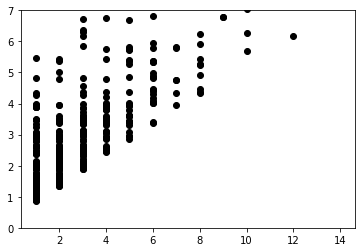

In [407]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

scaler = StandardScaler()
pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=77)
regr = LinearRegression()
regr.fit(X_train, y_train)
predictions = regr.predict(X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, predictions))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, predictions))

# Plot outputs
plt.scatter(y_test, predictions, color="black")
plt.ylim(0, 7)

In [408]:
coeff_df = pd.DataFrame(regr.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
weight,-0.000213
height,0.019642
rookie_year,0.000655
num_seasons,0.470827
position_firstbaseman,0.085784
position_outfielder,0.089489
position_secondbaseman,0.247132
position_shortstop,0.225408
position_thirdbaseman,0.048062
bat_hand_L,-0.047458


In [409]:
from sklearn import metrics
print("MAE:", metrics.mean_absolute_error(y_test, predictions))
print("MSE:", metrics.mean_squared_error(y_test, predictions))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.7701227245017317
MSE: 1.367431856293086
RMSE: 1.1693724198445448


In [410]:
metrics.explained_variance_score(y_test, predictions)

0.6221290830309076

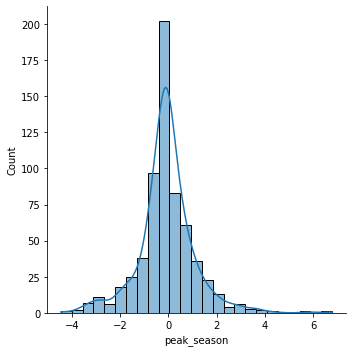

In [411]:
sns.displot(y_test - predictions, bins=25, kde=True);

In [419]:
test_data_with_pred = X_test.copy()
test_data_with_pred['pred_peak_season'] = predictions
test_data_with_pred = pd.concat([player_pk_perf_df.drop(['peak_games'], axis=1), test_data_with_pred['pred_peak_season']], axis=1, join='inner')
test_data_with_pred['position_group'] = test_data_with_pred['position'].apply(lambda x: 'catcher' if x == 'catcher' else 'outfielder' if x == 'outfielder' else 'infielder')
test_data_with_pred.head()


,name,weight,height,bat_hand,throw_hand,position,rookie_year,num_seasons,peak_season,pred_peak_season,position_group
player_id,,,,,,,,,,,
adamsbu01,Buster Adams,180,72,R,R,outfielder,1939,2,2,1.514999,outfielder
aikenwi01,Willie Aikens,220,75,L,R,firstbaseman,1977,1,1,1.099504,infielder
alexada01,Dale Alexander,210,75,R,R,firstbaseman,1929,3,1,2.028099,infielder
alfoned01,Edgardo Alfonzo,210,71,R,R,thirdbaseman,1995,6,4,3.367539,infielder
alicelu01,Luis Alicea,165,69,B,R,secondbaseman,1988,1,1,1.209387,infielder


''

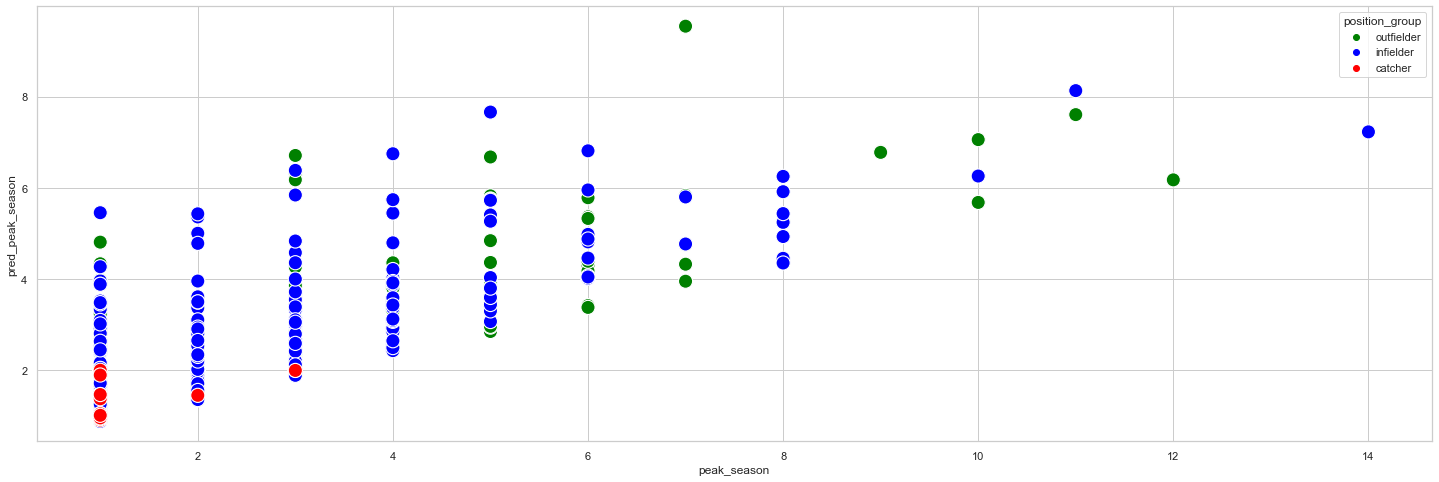

In [434]:
plt.figure(figsize=(25,8))
sns.set_style('whitegrid')
palette=dict(catcher='red', outfielder='green', infielder='blue')
sns.scatterplot(data=test_data_with_pred.sort_values(by=['position_group'], ascending=False), x='peak_season', y='pred_peak_season', hue='position_group', s=200, palette=palette)
''